In [2]:
import os
import urllib.request
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# ✅ 이미지 경로 설정 (환경 변수 이용)
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_actor.jpg'
img_background = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_background2.jpg'
img_puppy = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_puppy.jpeg'

In [3]:
# ✅ 이미지 로드
img_orig1 = cv2.imread(img_path)        # 인물 사진
img_orig2 = cv2.imread(img_background)  # 배경 이미지
img_orig3 = cv2.imread(img_puppy)       # 강아지 사진

In [4]:
# ✅ PixelLib 모델 다운로드 및 로드
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# ✅ PASCAL VOC 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [6]:
# ✅ 세그멘테이션 수행 (인물 이미지)
segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
# ✅ 사람 마스크 추출 (person = LABEL_NAMES[15] → RGB: (128, 128, 192))
person_color = (128, 128, 192)
seg_map = np.all(output == person_color, axis=-1)  # (H, W)

In [8]:
# ✅ 마스크 3채널로 확장
person_mask_3d = seg_map[:, :, np.newaxis]

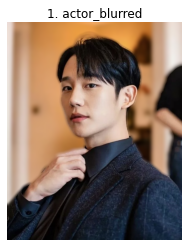

In [10]:
# ✅ 배경 블러 이미지 생성
img_blur = cv2.blur(img_orig1, (13, 13))

# ✅ 배경 블러 + 사람 원본 합성
final_img1 = np.where(person_mask_3d == 1, img_orig1, img_blur)

# ✅ 시각화
plt.imshow(cv2.cvtColor(final_img1, cv2.COLOR_BGR2RGB))
plt.title("1. actor_blurred")
plt.axis('off')
plt.show()

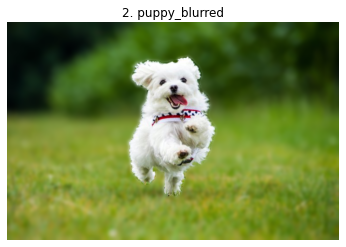

In [11]:
# ✅ 세그멘테이션 수행 (강아지 이미지)
output3, _ = model.segmentAsPascalvoc(img_puppy)
segvalues3 = output3

# ✅ 강아지 마스크 추출
dog_mask = segvalues3['masks'][:, :, 1] if segvalues3['masks'].ndim == 3 else segvalues3['masks']
dog_mask_3d = dog_mask[:, :, np.newaxis]

# ✅ 강아지 배경 블러 처리
img_blur_dog = cv2.GaussianBlur(img_orig3, (21, 21), 0)
final_img2 = np.where(dog_mask_3d == 1, img_orig3, img_blur_dog)

# ✅ 시각화
plt.imshow(cv2.cvtColor(final_img2, cv2.COLOR_BGR2RGB))
plt.title("2. puppy_blurred")
plt.axis('off')
plt.show()

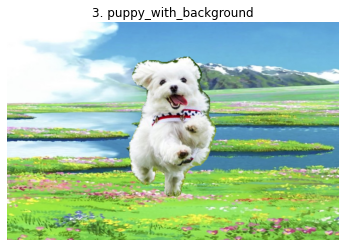

In [12]:
# ✅ 배경 이미지 강아지 사진 크기에 맞게 조절
background_resized = cv2.resize(img_orig2, (img_orig3.shape[1], img_orig3.shape[0]))

# ✅ 배경 바꾸기 (강아지만 원본, 나머지는 새로운 배경)
final_img3 = np.where(dog_mask_3d == 1, img_orig3, background_resized)

# ✅ 시각화
plt.imshow(cv2.cvtColor(final_img3, cv2.COLOR_BGR2RGB))
plt.title("3. puppy_with_background")
plt.axis('off')
plt.show()

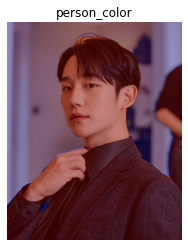

In [14]:
# 원본 이미지 복사
img_overlay = img_orig1.copy()

# 마스크를 0과 255로 변환하여 컬러맵 적용
mask_uint8 = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(mask_uint8, cv2.COLORMAP_JET)

# 원본 이미지와 컬러 마스크 합성 (가중치 조절)
overlay_result = cv2.addWeighted(img_overlay, 0.6, color_mask, 0.4, 0)

# 결과 시각화
plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
plt.title("person_color")
plt.axis('off')
plt.show()


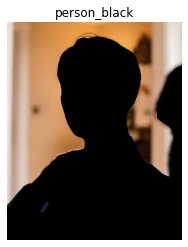

In [18]:
# 1. 세그멘테이션 수행
segvalues, output = model.segmentAsPascalvoc(img_path)

# 2. 'person' 클래스의 RGB 색상 (PASCAL VOC 기준)
person_color = (128, 128, 192)

# 3. 사람 영역 마스크 생성 (2D)
seg_map = np.all(output == person_color, axis=-1)  # (H, W), dtype=bool

# 4. 원본 이미지 복사
img_blackout = img_orig1.copy()

# 5. 인물 부분만 검정색으로 덮기 (각 채널에 대해 마스크 적용)
img_blackout[seg_map] = [0, 0, 0]  # RGB 전체 채널에 0값 넣기

# 6. 시각화
plt.imshow(cv2.cvtColor(img_blackout, cv2.COLOR_BGR2RGB))
plt.title("person_black")
plt.axis('off')
plt.show()

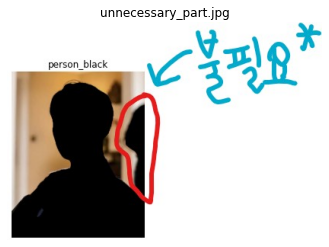

In [19]:
# ✅ 이미지 경로 지정 (확장자 포함)
image_path = os.path.join(os.getenv('HOME'), 'aiffel/human_segmentation/images/unnecessary_part.jpg')

# ✅ 이미지 읽기 (BGR 형식)
img = cv2.imread(image_path)

# ✅ 이미지가 정상적으로 불러와졌는지 확인
if img is None:
    print("이미지를 찾을 수 없습니다. 경로 또는 파일명을 확인하세요.")
else:
    # ✅ BGR → RGB 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ✅ 이미지 출력
    plt.imshow(img_rgb)
    plt.title("unnecessary_part.jpg")
    plt.axis('off')
    plt.show()

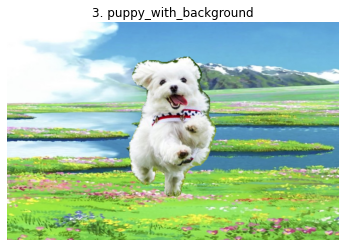

In [28]:
# ✅ 세그멘테이션 수행 (강아지 이미지)
output3, _ = model.segmentAsPascalvoc(img_puppy)
segvalues3 = output3

# ✅ 강아지 마스크 추출
dog_mask = segvalues3['masks'][:, :, 1] if segvalues3['masks'].ndim == 3 else segvalues3['masks']
dog_mask_3d = dog_mask[:, :, np.newaxis]

# 강아지를 나타내는 마스크를 가져옵니다.
dog_mask = segvalues3['masks'][:, :, 1] if segvalues3['masks'].ndim == 3 else segvalues3['masks']
# 마스크 개선: 경계 보정
kernel = np.ones((50, 0), np.uint8)
dog_mask_cleaned = cv2.morphologyEx(dog_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)  # 작은 구멍 메우기
dog_mask_cleaned = cv2.morphologyEx(dog_mask_cleaned, cv2.MORPH_OPEN, kernel)  # 노이즈 제거

# ✅ 시각화
plt.imshow(cv2.cvtColor(final_img3, cv2.COLOR_BGR2RGB))
plt.title("3. puppy_with_background")
plt.axis('off')
plt.show()

In [ ]:
<인물모드 사진의 문제점 개선 솔루션>

1. 세그멘테이션 정확도 향상:
- 정확한 모델 선택: 다른 딥러닝 세그멘테이션 모델(예: Mask R-CNN, U-Net 등)을 사용하여 인물 마스크의 정확도를 높입니다.
- 데이터셋 추가: 다양한 인물 사진으로 모델을 미세 조정(fine-tuning)하여 특정 환경에서의 성능을 개선합니다.

2. 마스크 개선:
- 경계 보정: cv2.morphologyEx()를 사용하여 마스크의 경계를 부드럽게 할 수 있습니다. 예를 들어, cv2.MORPH_CLOSE를 사용하여 작은 구멍을
메우고, cv2.MORPH_OPEN을 사용하여 노이즈를 제거합니다.

3. 블러링 기술 개선:
- 가우시안 블러: cv2.GaussianBlur()를 사용하여 블러 효과를 조절할 수 있습니다. 이 방법은 경계가 더 부드럽고 자연스럽게 보이게 합니다.

4. 합성 기술 조정:
- 가중치 합성: 배경 이미지를 블러 처리한 후 인물과 블렌딩할 때 가중치를 추가하여 부드러운 전환을 만들 수 있습니다.

5. 사용자 조정:
- 마스크 수동 조정: 최종 이미지를 생성하기 전에 사용자가 마스크를 수동으로 조정할 수 있는 기능을 추가하여 더 나은 결과를 얻을 수 있습니다.

6. 다양한 블러 효과 실험:
- 여러 블러 효과(예: 모션 블러, 원형 블러)를 실험하여 최적의 효과를 찾습니다.
이러한 방법들을 통해 인물과 배경의 분리를 더욱 정교하게 하고, 최종 이미지 품질을 향상시킬 수 있습니다.

In [ ]:
<후기>
- 오 귀여운 사진을 계속보며 진행하니까 엄청 재밌었고,
강아지가 정말 뛰어다니는 느낌으로 자연스럽게 보정하고 싶어서 경계면을 부드럽게 하는 과정을 진행해봤는데 적용이 잘 안 되어서 아쉬웠다.
이번 과정을 통해 내가 평소에 실사용하고 있는 어플들이 어떤 원리로 작동하는지 알게 되었고.
- 여전히 오류가 났을때 즉각적으로 해결해내는 것이 어려웠다.
- 앞으로도 열심히 킵고잉!! 